In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
import plotly.express as px
from geopandas.tools import overlay
import mapclassify as mc

In [2]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)

# Dropping all of the columns which we will not use
listingsNYC= listingsNYC.drop(['last_review','license','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float,
    
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,log_price
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,21,3,0.03,1,267,1,5775,5.616771
1,5203,Cozy Clean Guest Room - Family Apt,7490,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,2,118,0.73,1,0,0,150,4.317488
2,5121,BlissArtsSpace!,7356,Brooklyn,Bedford-Stuyvesant,40.685350,-73.955120,Private room,60,30,50,0.30,2,322,0,1800,4.094345
3,5178,Large Furnished Room Near B'way,8967,Manhattan,Midtown,40.764570,-73.983170,Private room,68,2,559,3.38,1,79,50,136,4.219508
4,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.753560,-73.985590,Entire home/apt,175,30,49,0.31,3,365,1,5250,5.164786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,769580756557673403,Cozy 1 bedroom with 2 full beds ROOM #2,162927656,Queens,Jamaica,40.693422,-73.804985,Shared room,99,1,1,1.00,7,174,1,99,4.595120
41160,769612968972941927,Comfortable 1 bedroom ROOM #3,162927656,Queens,Jamaica,40.691520,-73.805300,Shared room,91,1,1,1.00,7,174,1,91,4.510860
41175,770593748958588679,Luxury Brooklyn apt. | 10 mins away from JFK,489532090,Brooklyn,East New York,40.666019,-73.857968,Entire home/apt,145,1,2,2.00,1,351,2,145,4.976734
41218,769850569510129629,Private Bed Manhattan 20 Mins,324722741,Queens,Woodside,40.746040,-73.909110,Private room,50,1,1,1.00,1,240,1,50,3.912023


In [3]:
nyc_map = gpd.read_file("neighbourhoods.geojson")
nyc_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
nyc_map

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ..."
1,Allerton,Bronx,"MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ..."
2,City Island,Bronx,"MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ..."
3,Ditmars Steinway,Queens,"MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ..."
4,Ozone Park,Queens,"MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ..."
...,...,...,...
228,Westchester Square,Bronx,"MULTIPOLYGON (((-73.84294 40.84640, -73.83913 ..."
229,Westerleigh,Staten Island,"MULTIPOLYGON (((-74.13131 40.62633, -74.13192 ..."
230,Williamsbridge,Bronx,"MULTIPOLYGON (((-73.86722 40.86969, -73.86701 ..."
231,Williamsburg,Brooklyn,"MULTIPOLYGON (((-73.95757 40.72510, -73.95300 ..."


In [7]:
neighborhood_counts = listingsNYC.groupby('neighbourhood').count()
neighborhood_counts=neighborhood_counts[['id']]
neighborhood_counts.rename(columns={'id':'neighborhood_count'}, inplace=True)
neighborhood_means = listingsNYC.groupby('neighbourhood').mean()
neighborhood_means=neighborhood_means[['latitude','longitude','price']]
neighborhood_means_and_counts= pd.merge(neighborhood_counts,neighborhood_means, on='neighbourhood')
neighborhood_means_and_counts

,neighborhood_count,latitude,longitude,price
neighbourhood,,,,
Allerton,45,40.864974,-73.858897,112.244444
Arden Heights,4,40.551897,-74.175929,134.250000
Arrochar,17,40.592589,-74.071510,132.117647
Arverne,109,40.592835,-73.795136,191.330275
Astoria,601,40.764937,-73.920717,123.608985
...,...,...,...,...
Windsor Terrace,100,40.655011,-73.978425,161.530000
Woodhaven,85,40.691838,-73.859079,91.776471
Woodlawn,9,40.898721,-73.866208,129.333333


In [12]:
geo_neighborhood_means_and_counts = gpd.GeoDataFrame(neighborhood_means_and_counts,geometry = gpd.points_from_xy(neighborhood_means_and_counts.longitude, neighborhood_means_and_counts.latitude))
geo_neighborhood_means_and_counts

,neighborhood_count,latitude,longitude,price,geometry
neighbourhood,,,,,
Allerton,45,40.864974,-73.858897,112.244444,POINT (-73.85890 40.86497)
Arden Heights,4,40.551897,-74.175929,134.250000,POINT (-74.17593 40.55190)
Arrochar,17,40.592589,-74.071510,132.117647,POINT (-74.07151 40.59259)
Arverne,109,40.592835,-73.795136,191.330275,POINT (-73.79514 40.59284)
Astoria,601,40.764937,-73.920717,123.608985,POINT (-73.92072 40.76494)
...,...,...,...,...,...
Windsor Terrace,100,40.655011,-73.978425,161.530000,POINT (-73.97843 40.65501)
Woodhaven,85,40.691838,-73.859079,91.776471,POINT (-73.85908 40.69184)
Woodlawn,9,40.898721,-73.866208,129.333333,POINT (-73.86621 40.89872)


In [13]:
scheme = mc.Quantiles(geo_neighborhood_means_and_counts['price'], k=5)


Text(0.5, 1.0, 'Average Price of Neighborhood Listing')

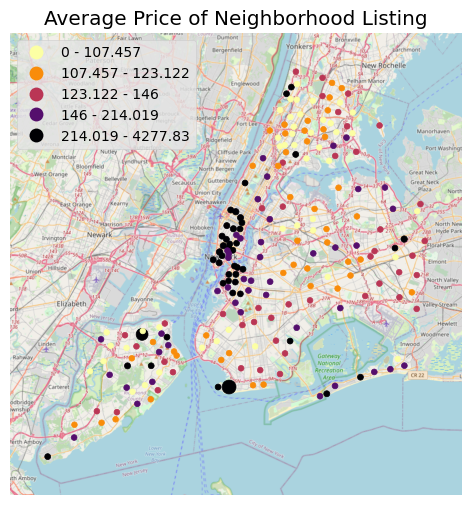

In [29]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_neighborhood_means_and_counts,
    hue='price',
    scale='price', limits=(4, 10),
    legend=True, legend_var='hue',
    scheme=scheme,
    cmap= 'inferno_r',
    ax=ax)
plt.title('Average Price of Neighborhood Listing')

Text(0.5, 1.0, 'Largest Neighborhood counts and their prices')

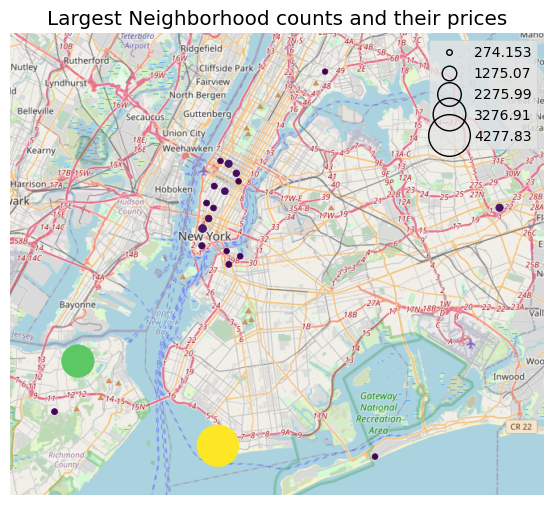

In [36]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_top_20_price,
    hue='price',
    scale='price', limits=(4, 30),
    legend=True, legend_var='scale',
    ax=ax)
plt.title('Largest Neighborhood counts and their prices')